<h1> [For Google Collab] Import file </h1>

In [ ]:
from google.colab import files
uploaded = files.upload()

<h1> Import libraries and datasets </h1>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
sb.set(style="darkgrid")

from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


<h1>Create dataframe as df </h1>


In [ ]:
df = pd.read_csv('cleaned_postings_final.csv')
del df["Unnamed: 0"]
df.head()

,job_id,fraudulent,company_profile_clen,description_clen,requirements_clen,benefits_clen,company_profile_wlen,description_wlen,requirements_wlen,benefits_wlen,combined_feature
0,1,0,885,905,852,14,141,124,115,1,marketing intern marketing intern US_ NY New_Y...
1,2,0,1286,2077,1433,1292,153,315,200,227,customer service cloud video production custom...
2,3,0,879,355,1363,14,141,50,164,1,commission machinery assistant cma commission ...
3,4,0,614,2600,1429,782,85,346,176,97,account executive washington dc account execut...
4,5,0,1628,1520,757,21,207,168,89,3,bill review manager bill review manager US_ FL...


<h1>Extract train and test data</h1>
<ol>
<li><b>Step 1:</b> Under sample majority</li>
<li><b>Step 2:</b> Convert text to vector using Count Vectorizer</li>
<li><b>Step 3:</b> Extract haracter length as a feature and noramlize the values</li>
<li><b>Step 4:</b> Convert charaacter length data to Compressed Sparse Row Matrix and marge with vectorized text</li>
<li><b>Step 5:</b> Split train and test set</li>
<li><b>Step 6:</b> Over sample the minority on training set</li>
</ol>


In [ ]:
def vectorizing_text(cv=CountVectorizer(),over=SMOTE(sampling_strategy=0.4),under=RandomUnderSampler(sampling_strategy=0.15)):
    global X_train, X_test, y_train, y_test
    #step 1
    data,label = under.fit_resample(df,df['fraudulent'])
    data = pd.DataFrame(data)

    #step 2
    extracted = cv.fit_transform(data[10]) #extracted = cv.fit_transform(data['combined_feature'])
    
    #step 3
    clen_data = pd.DataFrame(data[[2,3,4,5]])
    clen_data.astype(int)
    for i in clen_data.columns:
      max_value = clen_data[i].max()
      min_value = clen_data[i].min()
      value_range = max_value - min_value
      clen_data[i] = clen_data[i].apply(lambda x: (x-min_value)/value_range)
    
    #step 4 convert data to CSR and merge with CSR of tokenized text
    clen_matrix = csr_matrix(clen_data)
    extracted = hstack((clen_matrix, extracted))
    
    #step 5
    X_train, X_test, y_train, y_test = train_test_split(extracted, label, test_size=0.2, random_state=1)
    
    #step 6
    X_train, y_train = over.fit_resample(X_train, y_train)

vectorizing_text()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


<h1>Applying model</h1>
This part is a resuable function which receive the train, test data and the model as input. It will print out metric measures from different models and output necessary data for visualization part.

In [ ]:
def fitting_data(X_train, X_test, y_train, y_test, model, name, auc_dict):
    if name != 'Tensorflow':
        a=1
        model.fit(X_train, y_train)

        y_pred_train = model.predict(X_train)
        y_pred = model.predict(X_test)
    else :
        a=0
        y_pred_train = model.predict_classes(X_train)
        y_pred = model.predict_classes(X_test)
        # Evaluate the model on the test data using `evaluate`
        results_train = model.evaluate(X_train, y_train) 
        results_test = model.evaluate(X_test, y_test)              

    y_score_train = model.predict_proba(X_train)
    y_score_test = model.predict_proba(X_test)

    print("Training set")
    if name == 'Tensorflow':
        print("train loss, train acc:", results_train)
    print (accuracy_score(y_train, y_pred_train))
    print (confusion_matrix(y_train, y_pred_train))
    print (classification_report(y_train, y_pred_train))
    train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_score_train[:,a])
    print ('AUC score: ', auc(train_fpr,train_tpr))
    train_auc = auc(train_fpr,train_tpr)
    
    print("\nTest set")
    if name == 'Tensorflow':
        print("test loss, test acc:", results_test)
    print (accuracy_score(y_test, y_pred))
    print (confusion_matrix(y_test, y_pred))
    print (classification_report(y_test, y_pred))
    test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_score_test[:,a])
    print ('AUC score: ', auc(test_fpr,test_tpr))
    test_auc =  auc(test_fpr,test_tpr)
    print("\n")

    auc_dict['Algorithm'].append(name)
    auc_dict['AUC'].append(test_auc)
    return train_fpr, train_tpr, test_fpr, test_tpr, y_pred_train, y_pred, name

In [ ]:
def Tf_Results():
    model = tf_model
    y_test_pred = model.predict_classes(X_test_final)
    y_test_pred_p = model.predict_proba(X_test_final) == proba
    print("\nFor test data:")
    results = model.evaluate(X_test_final, y_test)     # Evaluate the model on the test data using `evaluate`
    print("test loss, test acc:", results)
    print("ROC AUC Score: ", roc_auc_score(y_test, y_test_pred_p)) #proba
    print("Accuracy Score: ", accuracy_score(y_test, y_test_pred)) #classes
    print("F1 Score: ", f1_score(y_test, y_test_pred))
    print("Confusion Matrix:\n ", confusion_matrix(y_test, y_test_pred))

<h1>Visualization</h1>
Plotting the ROC curve for different model

In [ ]:
def plotting(train_fpr, train_tpr, test_fpr, test_tpr, y_pred_train, y_pred, name):
    plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
    plt.plot([0,1],[0,1],'g--')
    plt.legend()
    plt.xlabel("True Positive Rate",fontsize=15)
    plt.ylabel("False Positive Rate",fontsize=15)
    plt.title(name,fontsize=20)
    plt.grid(color='black', linestyle='-', linewidth=0.5)

In [ ]:
data = {"Algorithm":[],"AUC":[]}

<h1>Models to use :</h1>
<ol>
<li><b>1.</b> Naive Bayes</li>
<li><b>2.</b> State Vector Machine</li>
<li><b>3.</b> Random Forest</li>
<li><b>4.</b> Neural Network (Tensorflow keras)</li>
</ol>


1. Naive Bayes

In [ ]:
nb = MultinomialNB()

train_fpr, train_tpr, test_fpr, test_tpr, y_pred_train, y_pred, name\
 = fitting_data(X_train, X_test, y_train, y_test, model=nb, name="Naive Bayes", auc_dict=data)

Training set
0.964874106310227
[[4427  169]
 [  57 1781]]
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      4596
           1       0.91      0.97      0.94      1838

    accuracy                           0.96      6434
   macro avg       0.95      0.97      0.96      6434
weighted avg       0.97      0.96      0.97      6434

AUC score:  0.9912777799875181

Test set
0.9322289156626506
[[1108   69]
 [  21  130]]
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1177
           1       0.65      0.86      0.74       151

    accuracy                           0.93      1328
   macro avg       0.82      0.90      0.85      1328
weighted avg       0.94      0.93      0.94      1328

AUC score:  0.9632610689428169




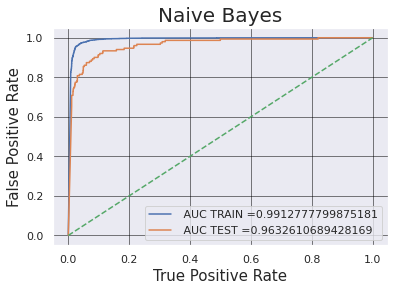

In [ ]:
plotting(train_fpr, train_tpr, test_fpr, test_tpr, y_pred_train, y_pred, name)

2. a) Sigmoid Kernel SVM

In [ ]:
sig_svm = SVC(probability=True,kernel='sigmoid')

train_fpr, train_tpr, test_fpr, test_tpr, y_pred_train, y_pred, name\
 = fitting_data(X_train, X_test, y_train, y_test, model=sig_svm, name="Sigmoid SVM", auc_dict=data)

Training set
0.9132732359341001
[[4338  258]
 [ 300 1538]]
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      4596
           1       0.86      0.84      0.85      1838

    accuracy                           0.91      6434
   macro avg       0.90      0.89      0.89      6434
weighted avg       0.91      0.91      0.91      6434

AUC score:  0.915195334733046

Test set
0.9081325301204819
[[1094   83]
 [  39  112]]
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1177
           1       0.57      0.74      0.65       151

    accuracy                           0.91      1328
   macro avg       0.77      0.84      0.80      1328
weighted avg       0.92      0.91      0.91      1328

AUC score:  0.8926218301102251




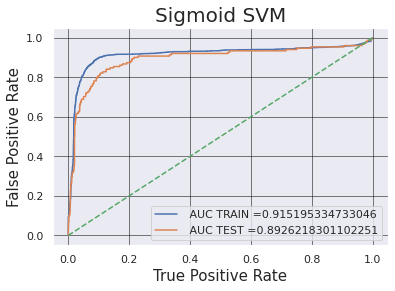

In [ ]:
plotting(train_fpr, train_tpr, test_fpr, test_tpr, y_pred_train, y_pred, name)

2. b) Linear SVM

In [ ]:
lin_svc = SVC(C= 5e-4 , probability=True,kernel='linear')

train_fpr, train_tpr, test_fpr, test_tpr, y_pred_train, y_pred, name\
 = fitting_data(X_train, X_test, y_train, y_test, model=lin_svc, name="Linear SVM", auc_dict=data)

Training set
0.9535281317998134
[[4434  162]
 [ 137 1701]]
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      4596
           1       0.91      0.93      0.92      1838

    accuracy                           0.95      6434
   macro avg       0.94      0.95      0.94      6434
weighted avg       0.95      0.95      0.95      6434

AUC score:  0.9909171385251498

Test set
0.9450301204819277
[[1130   47]
 [  26  125]]
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1177
           1       0.73      0.83      0.77       151

    accuracy                           0.95      1328
   macro avg       0.85      0.89      0.87      1328
weighted avg       0.95      0.95      0.95      1328

AUC score:  0.968637292026535




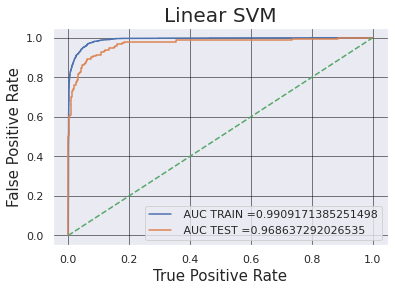

In [ ]:
plotting(train_fpr, train_tpr, test_fpr, test_tpr, y_pred_train, y_pred, name)

2. c) Polymonial SVM (Degree 2)

In [ ]:
svc2 = SVC(probability=True,kernel='poly',degree=2)

train_fpr, train_tpr, test_fpr, test_tpr, y_pred_train, y_pred, name\
 = fitting_data(X_train, X_test, y_train, y_test, model=svc2, name="Polymonial SVM", auc_dict=data)

Training set
0.9505750699409388
[[4588    8]
 [ 310 1528]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      4596
           1       0.99      0.83      0.91      1838

    accuracy                           0.95      6434
   macro avg       0.97      0.91      0.94      6434
weighted avg       0.95      0.95      0.95      6434

AUC score:  0.9983286076457648

Test set
0.9615963855421686
[[1168    9]
 [  42  109]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1177
           1       0.92      0.72      0.81       151

    accuracy                           0.96      1328
   macro avg       0.94      0.86      0.89      1328
weighted avg       0.96      0.96      0.96      1328

AUC score:  0.9679536592639273




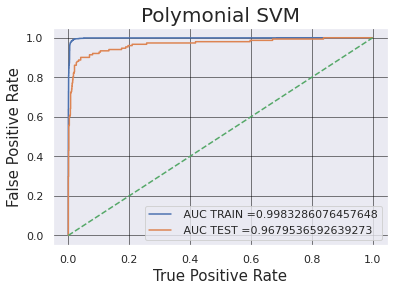

In [ ]:
plotting(train_fpr, train_tpr, test_fpr, test_tpr, y_pred_train, y_pred, name)

3. Decision Tree (Random Forest)

In [ ]:
rfc = RandomForestClassifier(max_depth=130, random_state=0)

train_fpr, train_tpr, test_fpr, test_tpr, y_pred_train, y_pred, name\
 = fitting_data(X_train, X_test, y_train, y_test, model=rfc, name="Random Forest Classifier", auc_dict=data)

Training set
1.0
[[4596    0]
 [   0 1838]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4596
           1       1.00      1.00      1.00      1838

    accuracy                           1.00      6434
   macro avg       1.00      1.00      1.00      6434
weighted avg       1.00      1.00      1.00      6434

AUC score:  1.0

Test set
0.9683734939759037
[[1174    3]
 [  39  112]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1177
           1       0.97      0.74      0.84       151

    accuracy                           0.97      1328
   macro avg       0.97      0.87      0.91      1328
weighted avg       0.97      0.97      0.97      1328

AUC score:  0.9866987008164206




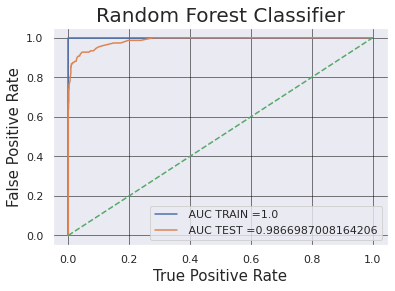

In [ ]:
plotting(train_fpr, train_tpr, test_fpr, test_tpr, y_pred_train, y_pred, name)

4. Tensorflow

Split train data into train, validation and test sets

In [ ]:
def split_sampling():
    under=RandomUnderSampler(sampling_strategy=0.25)
    data, label = under.fit_resample(df, df['fraudulent'])
    data = pd.DataFrame(data)
    X_train, X_test, y_train, y_test = train_test_split(data[2], label, test_size=0.2)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
    return X_train, X_val, X_test, y_train, y_val, y_test

def split():
    X_train, X_test, y_train, y_test = train_test_split(df['combined_feature'], df['fraudulent'], random_state=1, test_size=0.2)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=1, test_size=0.2)
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train_tf, X_val_tf, X_test_tf, y_train_tf, y_val_tf, y_test_tf = split()

Preprocess the data using tokenization and padding to be fitted into Tensorflow model

In [ ]:
vocab_size = 10000
embedding_dim = 32
max_length = 500
trunc_type='post'
oov_tok = "<OOV>"

def preprocess_tf(X_train=X_train_tf, X_val=X_val_tf, X_test=X_test_tf):
    global X_train_final, X_val_final, X_test_final

    tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok) #oov token is a token which represents unseen words
    tokenizer.fit_on_texts(X_train)
    word_index = tokenizer.word_index

    X_train_seq = tokenizer.texts_to_sequences(X_train)
    #padding is resizing length of sentences into same length by adding 0
    X_train_final = pad_sequences(X_train_seq, maxlen=max_length, truncating=trunc_type) 

    X_val_seq = tokenizer.texts_to_sequences(X_val)
    X_val_final = pad_sequences(X_val_seq, maxlen=max_length, truncating=trunc_type)

    X_test_seq = tokenizer.texts_to_sequences(X_test)
    X_test_final = pad_sequences(X_test_seq, maxlen=max_length)

preprocess_tf()

Define model for keras with 2 layers and 4 epochs

In [ ]:
def Tensorflow(X_train=X_train_final, X_val=X_val_final, y_train=y_train_tf, y_val=y_val_tf):
    global tf_model, history
    loss = 'binary_crossentropy'
    op = 'adam'
    num_epochs = 4
    class_weight = {0:15, 1:1}
    metric = [
            keras.metrics.BinaryAccuracy(name='accuracy'),
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.AUC(name='auc')
    ]
    
    #After preprocessing, define keras model with 2 layers and 3 epochs
    tf_model = tf.keras.Sequential([
          tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(16, activation='relu'),
          tf.keras.layers.Dropout(0.4),
          tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    tf_model.compile(loss=loss, optimizer=op, metrics=[metric])
    tf_model.summary()
    es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)
    history = tf_model.fit(X_train, y_train, epochs=num_epochs, validation_data=(X_val, y_val), class_weight=class_weight, callbacks=[es_callback])
Tensorflow()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           320000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 16000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                256016    
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 576,033
Trainable params: 576,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4
358/358 [==============================] - 4s 12ms/step - loss: 0.7416 - accuracy: 0.9468 - precision: 0

In [ ]:
train_fpr, train_tpr, test_fpr, test_tpr, y_pred_train, y_pred, name\
 = fitting_data(X_train_final, X_test_final, y_train_tf, y_test_tf, model=tf_model, name="Tensorflow", auc_dict=data)

112/112 [==============================] - 0s 2ms/step - loss: 0.0916 - accuracy: 0.9799 - precision: 0.9655 - recall: 0.5490 - auc: 0.9214
Training set
train loss, train acc: [0.031470611691474915, 0.9914358258247375, 1.0, 0.8301559686660767, 0.9902042746543884]
0.9914358122869876
[[10866     0]
 [   98   479]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     10866
           1       1.00      0.83      0.91       577

    accuracy                           0.99     11443
   macro avg       1.00      0.92      0.95     11443
weighted avg       0.99      0.99      0.99     11443

AUC score:  0.9992388768680771

Test set
test loss, test acc: [0.09161999076604843, 0.9798657894134521, 0.9655172228813171, 0.5490196347236633, 0.921387255191803]
0.9798657718120806
[[3420    3]
 [  69   84]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3423
           1       0.97      0.55      0.

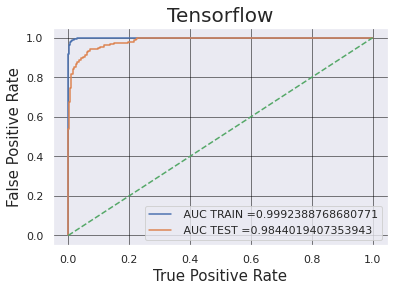

In [ ]:
plotting(train_fpr, train_tpr, test_fpr, test_tpr, y_pred_train, y_pred, name)

Print and compare the <b>AUC score</b> and <b>loss</b> of train set and validation set

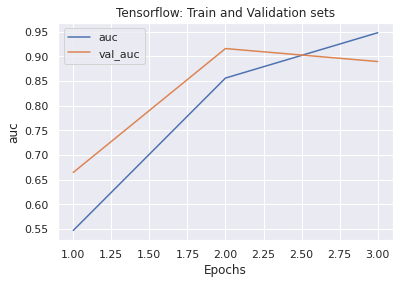

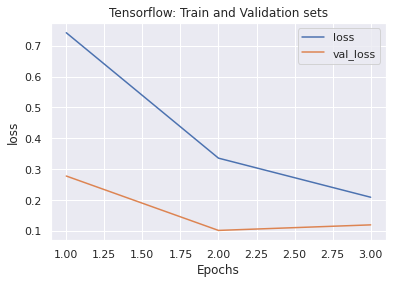

In [ ]:
def plot_graphs(history, string):
    plt.plot(np.arange(1,len(history.history[string])+1),history.history[string])
    plt.plot(np.arange(1,len(history.history[string])+1),history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.title("Tensorflow: Train and Validation sets")
    plt.show()
  
plot_graphs(history, 'auc')
plot_graphs(history, "loss")

<h1>Final Result</h1>
From the barchart, we could see <b>Random Forest</b> and <b>Neural Network</b> produce the best result. <b>Sigmoid SVM</b> gives significantly low result compare with other models. Among 3 remaining models, <b>Linear SVM</b> is slightly better, but difference is too small, we can conclude <b>Naive Bayes</b>, <b>Linear SVM</b> and <b>Polynomial SVM</b> are equally good.

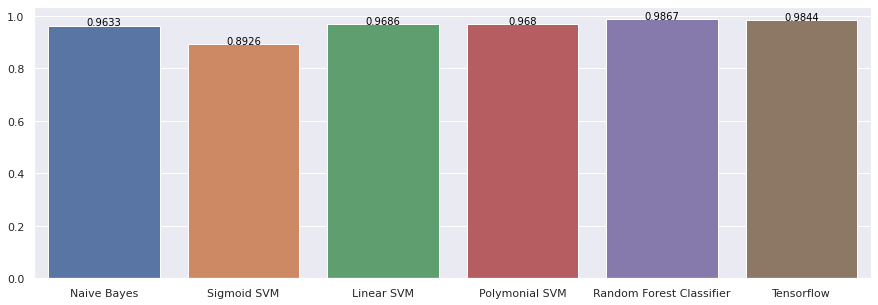

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
g=sb.barplot(x="Algorithm",y="AUC",data=data)
data = pd.DataFrame(data)
for index, row in data.iterrows():
    g.text(row.name,row["AUC"], round(row["AUC"],4), color='black', ha="center")